# EGM algorithm for simpel firm problem with 1 endogenous state

## Setup - import packages

In [1]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from SSJ_ext.het_block import het
import EGM_utils # helper functions for solving DP problem 
import SSJ_ext.utils as utils 
import SSJ_ext.jacobian as jac # to calculate jacobians for IRFs

from consav import golden_section_search
from numba import njit, prange
from consav import linear_interp

## The problem 
The following code solves the dynamic programming problem:
\begin{gather}
V_{t}\left(k_{t-1},z_{t}\right)=\max_{k_{t},\ell_{t},I_{t}}\pi\left(k_{t-1},\ell_{t},k_{t},z_{t}\right)+\beta_{t+1}E_{t}V_{t+1}\left(k_{t},z_{t+1}\right)
\end{gather}
subject to the constraints:
\begin{gather*}
y_{t}=z_{t}k_{t-1}^{\alpha^{k}}\ell_{t}^{\alpha^{\ell}} \\
\pi\left(k_{t-1},\ell_{t},k_{t},z_{t}\right)=p_{t}\left(y_{t}-\frac{\phi^{k}}{2}\left(\frac{k_{t}}{k_{t-1}}-1\right)^{2}k_{t-1}\right)-p_{t}^{I}I_{t}-w_{t}\ell_{t} \\
k_{t}=(1-\delta^{k})k_{t-1}+I_{t}
\end{gather*}
The first-order conditions used in the endogenous grid method are:
\begin{gather*}
p\alpha^{\ell}z_{t}k_{t-1}^{\alpha^{k}}\ell_{t}^{\alpha^{\ell}-1}=w_{t} \\
p_{t}^{I}+\phi^{k}\left(\frac{k_{t}}{k_{t-1}}-1\right)=\beta_{t+1}E_{t}\frac{\partial V_{t}\left(k_{t},z_{t+1}\right)}{\partial k_{t}} \\ 
\frac{\partial V_{t}\left(\ell_{t},k_{t},z_{t+1}\right)}{\partial k_{t}}=(1-\delta^{k})p_{t+1}^{I}+p_{t+1}\alpha^{k}z_{t+1}k_{t}^{\alpha^{k}-1}\ell_{t+1}^{\alpha^{\ell}}+p_{t+1}\frac{\phi^{k}}{2}\left(\left(\frac{k_{t+1}}{k_{t}}\right)^{2}-1\right)
\end{gather*}

# EGM backstep 

#### The function Firm_prop_simple does one backstep given (marginal) continuation values. Iterating on this function until convergence yields the fixed point of the problem 

In [17]:
@njit
def calc_flowprofit(k, z, k_grid, l, alphaK, alphaL, p, pI, w, phi_k, deltaK):
    N = z * k_grid**alphaK * l**alphaL - EGM_utils.get_gamma_derive(k, k_grid, phi_k)[0] 
    inv = k - (1-deltaK) * k_grid    
    return p * N - w * l - pI * inv

@het(exogenous='Pi_p', policy=['k'], backward=['mCont_val'])
def Firm_prop_simple(mCont_val_p, Pi_p, k_grid, z_grid, alphaK, alphaL, p, deltaK, phi_k, w, pI, interest):
    """Single backward iteration step using endogenous gridpoint method"""
    z = z_grid
    beta = 1/(1+interest)
    l = EGM_utils.inv_L_demand(w, alphaL, alphaK, z[:, np.newaxis], k_grid[np.newaxis, :], p)
    dphi_k1 = EGM_utils.get_gamma_derive(k_grid[:, np.newaxis], k_grid[np.newaxis, :], phi_k)[1] 

    # take expectation over future marginal continuation value
    E_mCont_val = beta * EGM_utils.matrix_times_first_dim(Pi_p, mCont_val_p) 
    
    # EGM-step and interpolation 
    rhs = E_mCont_val
    lhs = pI + p * dphi_k1
    i, pi = EGM_utils.lhs_equals_rhs_interpolate(rhs, lhs)
    k = utils.apply_coord(i, pi, k_grid)
    
    # calculate y 
    y = z[:, np.newaxis] * l**alphaL * k_grid**alphaK 
    
    # calculate marginal continuation value for further backwards iteration 
    dphi_k2 = EGM_utils.get_gamma_derive(k, k_grid[np.newaxis, :], phi_k)[2]
    MPK = p * alphaK * z[:, np.newaxis] * k_grid[np.newaxis, :]**(alphaK-1) * l**alphaL
    mCont_val = pI * (1-deltaK) + p * dphi_k2 + MPK
    flowprofit = calc_flowprofit(k, z[:, np.newaxis], k_grid[np.newaxis, :], l, alphaK, alphaL, p, pI, w, phi_k, deltaK)
    return k, l, y, mCont_val, flowprofit


## Choose parameters and solve for fixed point 

In [19]:
# parameters - relatively randomly chosen 
pars = {'alphaK' : 0.3, 'alphaL' : 0.4, 'p' : 1, 'pI' : 0.9, 'deltaK' : 0.1, 'phi_k' : 1, 'interest' : 0.05, 'w' : 0.5}

# grid for labor  
k_grid = 0.1   + utils.agrid(amax=8, n=250)

# grid for idiosynchratic productivty
# no heterogeighty for now to compare with jac solution (see below) so set variance to 0 (1e-08)
rho, sigma, NZ = 0.8, 1e-10, 5  # persistance, std and number of points in shock process for z 
z_grid, pi_e, Pi_p = utils.markov_rouwenhorst(rho, sigma, NZ)

# starting values for backwards iteration 
l = EGM_utils.inv_L_demand(pars['w'], pars['alphaL'], pars['alphaK'], z_grid[:, np.newaxis], k_grid[np.newaxis, :], pars['p'])
MPK = pars['p'] * pars['alphaK'] * z_grid[:, np.newaxis] * k_grid[np.newaxis, :]**(pars['alphaK']-1) * l**pars['alphaL']
mCont_val = np.zeros([NZ, len(k_grid)])
mCont_val += pars['pI'] * (1-pars['deltaK']) + MPK 

pars.update({'k_grid':k_grid, 'rho':rho, 'sigma':sigma, 'NZ':NZ,'mCont_val':mCont_val})

# iterate until steady state is reached 
Firm_prop_simple_het = Firm_prop_simple.attach_hetinput(EGM_utils.HET_add_ons)
ss = Firm_prop_simple_het.ss(**pars, accelerated_it = False, noisy=True, conv_var = 'policy')

print('SS value of labor and capital:', ss['L'],'and', ss['K'])

Iteration: 0
Converged after : 51 iterations
SS value of labor and capital: 1.3202840550611485 and 3.6675040901792753


## IRF to announced price shock 

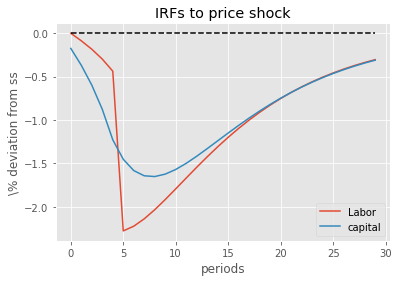

In [20]:
Time = 300     
# ttt = np.arange(0,Time)
ann = 5
sVar = 'p'
dp = np.zeros(Time)
dp[ann:] = - 0.01  * 0.9**(np.arange(Time-ann))
J      = Firm_prop_simple_het.jac(ss, Time, [sVar])  # get jacobian    

dL = J['L'][sVar] @ dp * 100 / ss['L']
dK = J['K'][sVar] @ dp * 100 / ss['K']

plt.plot(dL[:30], label='Labor')
plt.plot(dK[:30], label='capital')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('IRFs to price shock')
plt.ylabel(r'\% deviation from ss')
plt.xlabel(r'periods')
plt.legend()
plt.show() 

## Comparison

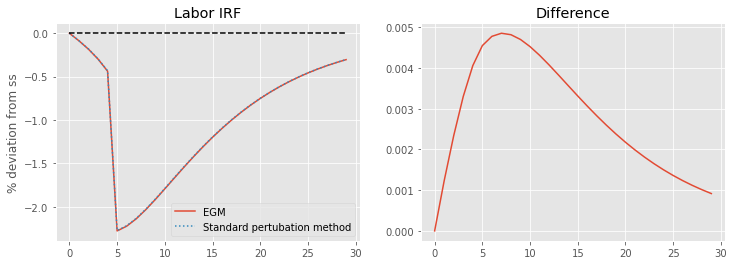

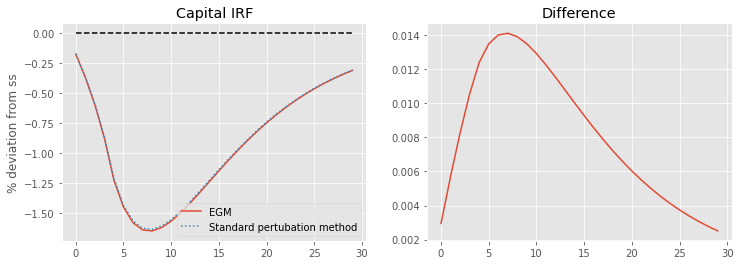

In [23]:
# Since there is no heterogeneity in the above model we can compare the solution to the one obtained 
# from a simple model solved using either standard pertubation methods (first-order approx. around steady-state as in dynare etc.)
# or compute full non-linear solution using a newton-solver.
# The solution using EGM and either of these methods should be identical (if grids for EGM are dense enough)

from solved_block import solved

# steady-state
def ss_res(x):
    K, L = x 
    beta = 1 /(1+ss['interest'])
    L_res = ss['alphaL']*ss['p']*K**(ss['alphaK'])*L**(ss['alphaL']-1) - ss['w'] 
    dphi1 = 0
    dphi2 = 0
    MPK_P = ss['p'] * ss['alphaK'] *K**(ss['alphaK']-1)*L**(ss['alphaL'])
    K_res = ss['p'] * dphi1 + ss['pI'] - beta * (ss['pI']*(1-ss['deltaK']) +  MPK_P + ss['p'] * dphi2)
    return np.array([K_res, L_res])

(K_simple, L_simple), _ = utils.broyden_solver(ss_res, np.array([ss['K'], ss['L']]), noisy=False)
# print(L_simple, K_simple)

# define block with equations
@solved(unknowns=['L', 'K'], targets=['L_res', 'K_res'])
def firm_block(alphaK, alphaL, interest, p, w, pI, Z, phi_k, L, K, deltaK):
    beta = 1 /(1+interest)
    L_res = alphaL*p*Z*K(-1)**(alphaK)*L**(alphaL-1) - w 
    dphi1 = phi_k * (K/K(-1)-1) 
    dphi2 = phi_k /2 * ((K(+1)/K)**2 -1)
    MPK_P = Z(+1) * p(+1) * alphaK *K**(alphaK-1)*L(+1)**(alphaL)
    K_res = p * dphi1 + pI - beta * (pI(+1)*(1-deltaK) +  MPK_P + p(+1) * dphi2)
    Y = Z * K(-1)**alphaK * L**alphaL
    return K_res, L_res, Y

ss_simple = {}
for k in ss:
    ss_simple[k] = ss[k]
ss_simple.update({'Z' : 1, 'K' : K_simple, 'L' : L_simple})

J_simple =   firm_block.jac(ss_simple, Time, [sVar])     

dL_simple = J_simple['L'][sVar] @ dp * 100 / ss_simple['L']
dK_simple   = J_simple['K'][sVar] @ dp * 100 / ss_simple['K']

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)

ax.plot(dL[:30], label='EGM')
ax.plot(dL_simple[:30], ':', label='Standard pertubation method')
ax.plot(np.zeros(30), color = 'black', linestyle = '--')
ax.set_title('Labor IRF')
ax.set_ylabel(r'% deviation from ss')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(abs(dL[:30] -dL_simple[:30]))
ax.set_title('Difference')
plt.show() 
        
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)

ax.plot(dK[:30], label='EGM')
ax.plot(dK_simple[:30], ':', label='Standard pertubation method')
ax.plot(np.zeros(30), color = 'black', linestyle = '--')
ax.set_title('Capital IRF')
ax.set_ylabel(r'% deviation from ss')
ax.legend(loc='best')

ax = fig.add_subplot(1,2,2)
ax.plot(abs(dK[:30] -dK_simple[:30]))
ax.set_title('Difference')
plt.show() 


### They coincide! hurray!

# With zero profit constraint

### First we increase variance of productivity shocks such that some firms will experience negative profits when following their Euler equation

Iteration: 0
Converged after : 71 iterations


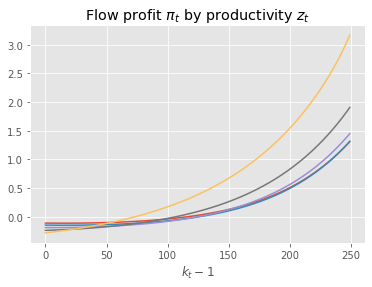

In [29]:
rho, sigma, NZ = 0.8, 0.4, 5
pars.update({'rho' : rho, 'sigma' : sigma, 'NZ' : NZ})
ss = Firm_prop_simple_het.ss(**pars, accelerated_it = False, noisy=True, conv_var = 'policy')

plt.plot(ss['flowprofit'].T)
plt.title(f'Flow profit $\pi_t$ by productivity $z_t$')
plt.xlabel(f'$k_t-1$')
plt.show()


## VFI

In [34]:
@njit
def profitfunc(k, jz, z_grid, k_grid, k_grid_full, l, alphaK, alphaL, p, pI, w, phi_k, deltaK, v_p, beta, Pi_p):
    flowprofit = calc_flowprofit(k, z_grid[jz], k_grid, l, alphaK, alphaL, p, pI, w, phi_k, deltaK)
    w = 0
    for j in range(len(z_grid)):
        w += Pi_p[jz, j] * linear_interp.interp_1d(k_grid_full, v_p[j,:], k)  
    
    # penalty to enforce profit constraint 
    pen = 0 
    if flowprofit < 1e-07:
        pen = abs(flowprofit) * 500  # penalty should be continuous in flowprofit to help optimizer 
    profit = flowprofit + beta * w - pen
    return -profit  # golden search minimizes so add minus 

@njit
def calc_flowprofit(k, z, k_grid, l, alphaK, alphaL, p, pI, w, phi_k, deltaK):
    N = z * k_grid**alphaK * l**alphaL - EGM_utils.get_gamma_derive(k, k_grid, phi_k)[0] 
    inv = k - (1-deltaK) * k_grid    
    return p * N - w * l - pI * inv

@het(exogenous='Pi_p', policy=['k'], backward=['v'])
def Firm_prop_VFI(v_p, Pi_p, k_grid, z_grid, alphaK, alphaL, p, deltaK, phi_k, w, pI, interest):
    """Single backward iteration step using endogenous gridpoint method"""
    z = z_grid
    beta = 1/(1+interest)

    k = np.zeros_like(v_p)
    v = np.zeros_like(v_p)
    for jz in range(len(z)):
        for jk in range(len(k_grid)):
            args = (jz, z_grid, k_grid[jk], k_grid, l[jz,jk], alphaK, alphaL, p, pI, w, phi_k, deltaK, v_p, beta, Pi_p)
            k[jz,jk] = golden_section_search.optimizer(profitfunc, 0.001, max(k_grid)*1.8, args=args, tol=1e-07)
            v[jz,jk] = -profitfunc(k[jz,jk], *args)
            
    flowprofit = calc_flowprofit(k, z[:, np.newaxis], k_grid[np.newaxis, :], l, alphaK, alphaL, p, pI, w, phi_k, deltaK)
    y = z[:, np.newaxis] * l**alphaL * k_grid[np.newaxis, :]**alphaK 

    return k, l, y, flowprofit, v


# initial value: Use maximized static profit 
static_opt_k = (1-pars['pI']/(pars['p'] * pars['phi_k'])) * k_grid
flow_profit = calc_flowprofit(static_opt_k, z_grid[:, np.newaxis], k_grid, l, pars['alphaK'], pars['alphaL'], pars['p'], pars['pI'], pars['w'], pars['phi_k'], pars['deltaK'])
pars['v'] = flow_profit 

Firm_prop_VFI_het = Firm_prop_VFI.attach_hetinput(EGM_utils.HET_add_ons)
ss_VFI = Firm_prop_VFI_het.ss(**pars, accelerated_it = False, noisy=True, conv_var = 'backwards', backward_tol = 1e-08)
print('SS value of labor and capital:', ss_VFI['L'],'and', ss_VFI['K'])


Iteration: 0
Iteration: 100
Max error: {'v': 0.0043650647687165645}
Iteration: 200
Max error: {'v': 3.319405093904493e-05}
Iteration: 300
Max error: {'v': 2.5242408341341616e-07}
Converged after : 371 iterations
SS value of labor and capital: 1.3755442838831446 and 4.2909853330011325


## EGM + VFI

In [38]:
from consav import golden_section_search
from numba import njit, prange
from consav import linear_interp


@het(exogenous='Pi_p', policy=['k'], backward=['mCont_val', 'v'])
def Firm_prop_simple_EGM_VFI(mCont_val_p, v_p, Pi_p, k_grid, z_grid, alphaK, alphaL, p, deltaK, phi_k, w, pI, interest):
    """Single backward iteration step using endogenous gridpoint method"""
    z = z_grid
    beta = 1/(1+interest)
    
    dphi1 = EGM_utils.get_gamma_derive(k_grid[:, np.newaxis], k_grid[np.newaxis, :], phi_k)[1] 
    
    # take expectation over future marginal continuation value
    E_mCont_val = beta * EGM_utils.matrix_times_first_dim(Pi_p, mCont_val_p) 
    
    # solve for todays capital input using dynamic FOC using interpolation (i.e. interpolate such that rhs = lhs)
    k_prior = k_grid[np.newaxis, :] / (1 + (E_mCont_val - pI) / (p * phi_k))
    
    rhs = E_mCont_val
    lhs = pI + p * dphi1
    i, pi = EGM_utils.lhs_equals_rhs_interpolate(rhs, lhs)
    k = utils.apply_coord(i, pi, k_grid)
    
    # calculate l and y 
    l = EGM_utils.inv_L_demand(w, alphaL, alphaK, z[:, np.newaxis], k_grid[np.newaxis, :], p)
    
    flowprofit = calc_flowprofit(k, z[:, np.newaxis], k_grid[np.newaxis, :], l, alphaK, alphaL, p, pI, w, phi_k, deltaK)
    v = np.zeros_like(v_p)
    s_con = np.zeros_like(v_p)
    # for choices of which imply non-positive profits we maximize profits using golden search 
    for jz in range(len(z)):
        for jk in range(len(k_grid)):
            args = (jz, z_grid, k_grid[jk], k_grid, l[jz,jk], alphaK, alphaL, p, pI, w, phi_k, deltaK, v_p, beta, Pi_p)
            if flowprofit[jz,jk] <= 0:  
                s_con[jz,jk] = 1 
                k[jz,jk] = golden_section_search.optimizer(profitfunc, 0.001, max(k_grid)*1.8,args=args,tol=1e-07)
            v[jz,jk] = -profitfunc(k[jz,jk], *args)
    
    flowprofit = calc_flowprofit(k, z[:, np.newaxis], k_grid[np.newaxis, :], l, alphaK, alphaL, p, pI, w, phi_k, deltaK)
    y = z[:, np.newaxis] * l**alphaL * k_grid[np.newaxis, :]**alphaK 
    
    # calculate marginal continuation value for further backwards iteration 
    dphi2 = EGM_utils.get_gamma_derive(k, k_grid[np.newaxis, :], phi_k)[2]
    MPK = p * alphaK * z[:, np.newaxis] * k_grid[np.newaxis, :]**(alphaK-1) * l**alphaL
    mCont_val = pI * (1-deltaK) + p * dphi2 + MPK

    return k, l, y, mCont_val, flowprofit, v, s_con

# iterate until steady state is reached 
Firm_prop_simple_EGM_VFI_het = Firm_prop_simple_EGM_VFI.attach_hetinput(EGM_utils.HET_add_ons)
ss_VFI_EGM = Firm_prop_simple_EGM_VFI_het.ss(**pars, accelerated_it = False, noisy=True, conv_var = ['v'], backward_tol = 1e-08)
print('SS value of labor and capital:', ss_VFI_EGM['L'],'and', ss_VFI_EGM['K'])



Iteration: 0
Iteration: 100
Max error: {'v': 0.005489585458356316}
Iteration: 200
Max error: {'v': 4.1745497526335384e-05}
Iteration: 300
Max error: {'v': 3.174533453886852e-07}
Converged after : 371 iterations
SS value of labor and capital: 1.7050301438081128 and 4.507997240312369



## Compare VFI and EGM-VFI solutions

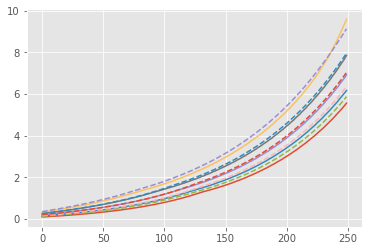

0.00017490614948805215


In [40]:
plt.plot(ss_VFI['k'].T, label = 'VFI')
plt.plot(ss_VFI_EGM['k'].T, '--', label='EGM-VFI - profit con.') # plot difference between VFI and EGM-VFI 
plt.show()

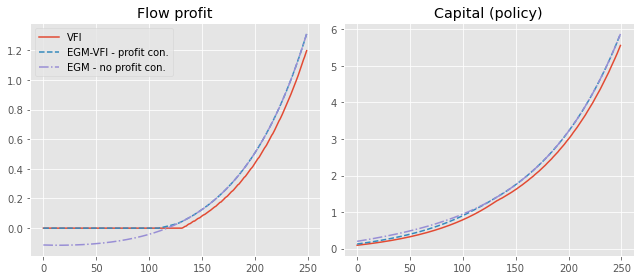

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))

ax1.plot(ss_VFI['flowprofit'][0,:], label = 'VFI')
ax1.plot(ss_VFI_EGM['flowprofit'][0,:], '--', label='EGM-VFI - profit con.') 
ax1.plot(ss['flowprofit'][0,:], '-.', label='EGM - no profit con.') 
ax1.legend()
ax1.set_title(f'Flow profit')

ax2.plot(ss_VFI['k'][0,:], label = 'VFI')
ax2.plot(ss_VFI_EGM['k'][0,:], '--', label='EGM-VFI - profit con.')
ax2.plot(ss['k'][0,:], '-.', label='EGM - no profit con.')
ax2.set_title(f'Capital (policy function)')

fig.tight_layout()
plt.show()